# Adaptive Clustering based Intrusion Detection


## Imports

In [2]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

from codecarbon import track_emissions
from datetime import datetime
import time


## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [2]:
def load_dataset(dataset_path_train, dataset_path_test):
    global categories
    if not os.path.exists(dataset_path_train):
        print(f"Dataset not found: {dataset_path_train}")
        sys.exit(1)
    if not os.path.exists(dataset_path_test):
        print(f"Dataset not found: {dataset_path_test}")
        sys.exit(1)

    train_df = pd.read_csv(dataset_path_train, index_col=False, sep=",")
    test_df = pd.read_csv(dataset_path_test, index_col=False, sep=",")

    
    # For binary classification, uncomment the following line
    train_df['Label.'] = np.where(train_df['Label.'] == 0, "Normal", "Attack")
    test_df['Label.'] = np.where(test_df['Label.'] == 0, "Normal", "Attack")
    


    return train_df, test_df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [3]:
@track_emissions
def train(X, y,j,dic_loss, lr=1e-4):

    dic_loss[f"entrainement_{j}"] = []

    batch_size = 1024
    print("Adaptive training...")
    model_ = AdaptiveClustering(encoder_dims=[500, 200, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()


    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

    n_epoch = 4
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

            loss = model_.loss()
            loss_value = loss.item()

            iteration_losses.append(loss_value)

            loss.backward()
            optimizer.step()
        dic_loss[f"entrainement_{j}"] += iteration_losses
        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [3]:
root_path = './'

dataset_path_train_1 = root_path + 'datasets/datasets_train_test/traindata1.csv'
dataset_path_test_1 = root_path + 'datasets/datasets_train_test/testdata1.csv'

dataset_path_train_2 = root_path + 'datasets/datasets_train_test/traindata2.csv'
dataset_path_test_2 = root_path + 'datasets/datasets_train_test/testdata2.csv'

dataset_path_train_3 = root_path + 'datasets/datasets_train_test/traindata3.csv'
dataset_path_test_3 = root_path + 'datasets/datasets_train_test/testdata3.csv'


results_path = root_path + f'results_ekip/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [4]:
model_path_1 = results_path + 'trained_model_1.pkl'
model_path_2 = results_path + 'trained_model_2.pkl'
model_path_3 = results_path + 'trained_model_3.pkl'

separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [6]:
print(separator)
print("Loading dataset...")

train_df_1, test_df_1 = load_dataset(dataset_path_train_1, dataset_path_test_1)
train_df_2, test_df_2 = load_dataset(dataset_path_train_2, dataset_path_test_2)
train_df_3, test_df_3 = load_dataset(dataset_path_train_3, dataset_path_test_3)

print("Done loading dataset ")


--------------------------------------------------
Loading dataset...
Done loading dataset 


In [7]:
train_df_1.head()
test_df_1.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label.
0,0,0,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,Normal
1,0,0,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13,13,1.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,Normal
2,0,0,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14,14,1.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,Normal
3,0,0,0,0,185,9020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20,20,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,Normal
4,0,0,0,0,199,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33,33,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,Normal


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [8]:
if os.path.exists(model_path_1 + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path_1 + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path_1}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df_1['Label.'])[1].values))
    print("Done creating categories...")

if os.path.exists(model_path_2 + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path_2 + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path_2}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df_2['Label.'])[1].values))
    print("Done creating categories...")

if os.path.exists(model_path_3 + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path_3 + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path_3}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df_3['Label.'])[1].values))
    print("Done creating categories...")


print("catégories de trafic traitées:",categories)




train_df1_ = train_df_1.drop(['Label.'], axis=1)
train_df2_ = train_df_2.drop(['Label.'], axis=1)
train_df3_ = train_df_3.drop(['Label.'], axis=1)

X1 = train_df1_.values.tolist()
y1 = train_df_1['Label.'].values.tolist()

X2 = train_df2_.values.tolist()
y2 = train_df_2['Label.'].values.tolist()

X3 = train_df3_.values.tolist()
y3 = train_df_3['Label.'].values.tolist()

X1 = torch.FloatTensor(np.array(X1))
X2 = torch.FloatTensor(np.array(X2))
X3 = torch.FloatTensor(np.array(X3))

for i, l in enumerate(y1):
    y1[i] = categories.index(l)

for i, l in enumerate(y2):
    y2[i] = categories.index(l)

for i, l in enumerate(y3):
    y3[i] = categories.index(l)

y1 = torch.LongTensor(np.array(y1))
y2 = torch.LongTensor(np.array(y2))
y3 = torch.LongTensor(np.array(y3))


# df.drop(['Label.'], axis=1, inplace=True)

Creating categories...
Done creating categories...
Creating categories...
Done creating categories...
Creating categories...
Done creating categories...
catégories de trafic traitées: ['Normal', 'Attack']


## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [9]:
if not os.path.exists(model_path_1):
    global dic_loss_1
    dic_loss_1 = {}
    dico_temps_1 = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model_1 = train(X1, y1, 1,dic_loss_1)
    durée = time.time() - debut
    dico_temps_1["entrainement_1"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss_1.pkl", 'wb') as file:
        pkl.dump(dic_loss_1, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps_1.pkl", 'wb') as file:
        pkl.dump(dico_temps_1, file)

    print("Done training model")

if not os.path.exists(model_path_2):
    global dic_loss_2
    dic_loss_2 = {}
    dico_temps_2 = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model_2 = train(X2, y2, 2,dic_loss_2)
    durée = time.time() - debut
    dico_temps_2["entrainement_2"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss_2.pkl", 'wb') as file:
        pkl.dump(dic_loss_2, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps_2.pkl", 'wb') as file:
        pkl.dump(dico_temps_2, file)
        
    print("Done training model")

if not os.path.exists(model_path_3):
    global dic_loss_3
    dic_loss_3 = {}
    dico_temps_3 = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model_3 = train(X3, y3, 3,dic_loss_3)
    durée = time.time() - debut
    dico_temps_3["entrainement_3"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss_3.pkl", 'wb') as file:
        pkl.dump(dic_loss_3, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps_3.pkl", 'wb') as file:
        pkl.dump(dico_temps_3, file)
        
    print("Done training model")


[codecarbon WARNING @ 23:53:48] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 23:53:48] [setup] RAM Tracking...
[codecarbon INFO @ 23:53:48] [setup] GPU Tracking...


Training model...


[codecarbon INFO @ 23:53:49] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:53:49] [setup] CPU Tracking...
[codecarbon WARNING @ 23:53:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:53:51] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 23:53:51] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 238, in get_gpu_details
    devices_info.append(gpu_device.get_gpu_details())
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 75, in get_gpu_details
    "power_usage": self._get_power_usage(),
                   ^^^^^^^^^^

Adaptive training...


[codecarbon INFO @ 23:54:10] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 23:54:12] Energy consumed for all GPUs : 0.000006 kWh. Total GPU Power : 1.4334797211779353 W
[codecarbon INFO @ 23:54:12] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 23:54:12] 0.000135 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:54:25] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 23:54:27] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 1.9440805934015115 W
[codecarbon INFO @ 23:54:27] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 23:54:27] 0.000259 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:54:40] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 23:54:42] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 1.8716315237798

Iteration 0 | Loss 0.14829683238776672


[codecarbon INFO @ 00:03:56] Energy consumed for RAM : 0.000895 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:03:57] Energy consumed for all GPUs : 0.000346 kWh. Total GPU Power : 1.8082452316629067 W
[codecarbon INFO @ 00:03:57] Energy consumed for all CPUs : 0.003762 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:03:57] 0.005003 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:11] Energy consumed for RAM : 0.000918 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:04:12] Energy consumed for all GPUs : 0.000353 kWh. Total GPU Power : 1.8399758106370605 W
[codecarbon INFO @ 00:04:12] Energy consumed for all CPUs : 0.003856 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:04:12] 0.005127 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:26] Energy consumed for RAM : 0.000940 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:04:27] Energy consumed for all GPUs : 0.000360 kWh. Total GPU Power : 1.8089047460954

Iteration 1 | Loss 0.012581441904585556


[codecarbon INFO @ 00:13:41] Energy consumed for RAM : 0.001764 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:13:42] Energy consumed for all GPUs : 0.000626 kWh. Total GPU Power : 1.9206072410261148 W
[codecarbon INFO @ 00:13:42] Energy consumed for all CPUs : 0.007420 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:13:42] 0.009810 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:13:56] Energy consumed for RAM : 0.001787 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:13:57] Energy consumed for all GPUs : 0.000634 kWh. Total GPU Power : 1.8803469836763034 W
[codecarbon INFO @ 00:13:57] Energy consumed for all CPUs : 0.007514 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:13:57] 0.009934 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:14:11] Energy consumed for RAM : 0.001809 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:14:12] Energy consumed for all GPUs : 0.000641 kWh. Total GPU Power : 1.8216834629442

Iteration 2 | Loss 0.00781673107745802


[codecarbon INFO @ 00:23:26] Energy consumed for RAM : 0.002636 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:23:28] Energy consumed for all GPUs : 0.000999 kWh. Total GPU Power : 1.8899330561937993 W
[codecarbon INFO @ 00:23:28] Energy consumed for all CPUs : 0.011078 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:23:28] 0.014713 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:23:41] Energy consumed for RAM : 0.002658 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:23:43] Energy consumed for all GPUs : 0.001006 kWh. Total GPU Power : 1.8616069327935612 W
[codecarbon INFO @ 00:23:43] Energy consumed for all CPUs : 0.011172 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:23:43] 0.014836 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:23:56] Energy consumed for RAM : 0.002680 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:23:58] Energy consumed for all GPUs : 0.001013 kWh. Total GPU Power : 1.8528591847830

Iteration 3 | Loss 0.006050690067350085


[codecarbon INFO @ 00:32:47] Energy consumed for all GPUs : 0.001272 kWh. Total GPU Power : 3.6828215395357358 W
[codecarbon INFO @ 00:32:47] Energy consumed for all CPUs : 0.014575 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:32:47] 0.019314 kWh of electricity used since the beginning.
C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
[codecarbon INFO @ 00:32:47] Done!

[codecarbon WARNING @ 00:32:47] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 00:32:47] [setup] RAM Track

Done training model
Training model...


[codecarbon INFO @ 00:32:49] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 00:32:49] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 238, in get_gpu_details
    devices_info.append(gpu_device.get_gpu_details())
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 75, in get_gpu_details
    "power_usage": self._get_power_usage(),
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 127, in _get_powe

Adaptive training...


[codecarbon INFO @ 00:33:08] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:33:10] Energy consumed for all GPUs : 0.000009 kWh. Total GPU Power : 2.1840926898856035 W
[codecarbon INFO @ 00:33:10] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:33:10] 0.000138 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:33:23] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:33:25] Energy consumed for all GPUs : 0.000017 kWh. Total GPU Power : 1.8446690094343607 W
[codecarbon INFO @ 00:33:25] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:33:25] 0.000261 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:33:38] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:33:40] Energy consumed for all GPUs : 0.000024 kWh. Total GPU Power : 1.9255716728802

Iteration 0 | Loss 0.07362737525889647


[codecarbon INFO @ 00:42:39] Energy consumed for RAM : 0.000871 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:42:40] Energy consumed for all GPUs : 0.000283 kWh. Total GPU Power : 1.8448031653142452 W
[codecarbon INFO @ 00:42:40] Energy consumed for all CPUs : 0.003668 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:42:40] 0.004822 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:42:54] Energy consumed for RAM : 0.000894 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:42:55] Energy consumed for all GPUs : 0.000290 kWh. Total GPU Power : 1.854773797471237 W
[codecarbon INFO @ 00:42:55] Energy consumed for all CPUs : 0.003762 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:42:55] 0.004945 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:09] Energy consumed for RAM : 0.000916 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:43:10] Energy consumed for all GPUs : 0.000297 kWh. Total GPU Power : 1.87593413252189

Iteration 1 | Loss 0.008051034149081454


[codecarbon INFO @ 00:52:09] Energy consumed for RAM : 0.001718 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:52:10] Energy consumed for all GPUs : 0.000556 kWh. Total GPU Power : 1.843288649427026 W
[codecarbon INFO @ 00:52:10] Energy consumed for all CPUs : 0.007232 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:52:10] 0.009506 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:52:24] Energy consumed for RAM : 0.001740 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:52:25] Energy consumed for all GPUs : 0.000563 kWh. Total GPU Power : 1.819740512869277 W
[codecarbon INFO @ 00:52:25] Energy consumed for all CPUs : 0.007326 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 00:52:25] 0.009629 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:52:39] Energy consumed for RAM : 0.001762 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 00:52:40] Energy consumed for all GPUs : 0.000570 kWh. Total GPU Power : 1.852844147646689

Iteration 2 | Loss 0.0047741539839810665


[codecarbon INFO @ 01:01:39] Energy consumed for RAM : 0.002564 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:01:40] Energy consumed for all GPUs : 0.000829 kWh. Total GPU Power : 1.88807207461261 W
[codecarbon INFO @ 01:01:40] Energy consumed for all CPUs : 0.010796 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:01:40] 0.014190 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:54] Energy consumed for RAM : 0.002587 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:01:55] Energy consumed for all GPUs : 0.000837 kWh. Total GPU Power : 2.0486911562307863 W
[codecarbon INFO @ 01:01:55] Energy consumed for all CPUs : 0.010890 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:01:55] 0.014314 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:02:09] Energy consumed for RAM : 0.002609 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:02:10] Energy consumed for all GPUs : 0.000844 kWh. Total GPU Power : 1.798545985641565

Iteration 3 | Loss 0.0036375741542926335


[codecarbon INFO @ 01:11:10] Energy consumed for all GPUs : 0.001104 kWh. Total GPU Power : 1.979142111153391 W
[codecarbon INFO @ 01:11:10] Energy consumed for all CPUs : 0.014354 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:11:10] 0.018867 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:11:10] Done!

[codecarbon WARNING @ 01:11:10] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 01:11:10] [setup] RAM Tracking...
[codecarbon INFO @ 01:11:10] [setup] GPU Tracking...
[codecarbon INFO @ 01:11:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:11:10] [setup] CPU Tracking...
[codecarbon WARNING @ 01:11:10] No CPU tracking mode found. Falling back on CPU constant mode.


Done training model
Training model...


[codecarbon INFO @ 01:11:11] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 01:11:12] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 238, in get_gpu_details
    devices_info.append(gpu_device.get_gpu_details())
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 75, in get_gpu_details
    "power_usage": self._get_power_usage(),
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 127, in _get_powe

Adaptive training...


[codecarbon INFO @ 01:11:31] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:11:32] Energy consumed for all GPUs : 0.000006 kWh. Total GPU Power : 1.465348910739953 W
[codecarbon INFO @ 01:11:32] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:11:32] 0.000136 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:11:46] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:11:47] Energy consumed for all GPUs : 0.000013 kWh. Total GPU Power : 1.8285011074386994 W
[codecarbon INFO @ 01:11:47] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:11:47] 0.000259 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:12:01] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:12:02] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 1.97142104867952

Iteration 0 | Loss 0.17745364293797108


[codecarbon INFO @ 01:21:01] Energy consumed for RAM : 0.000872 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:21:02] Energy consumed for all GPUs : 0.000284 kWh. Total GPU Power : 1.8795005734422374 W
[codecarbon INFO @ 01:21:02] Energy consumed for all CPUs : 0.003668 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:21:02] 0.004824 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:21:16] Energy consumed for RAM : 0.000895 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:21:17] Energy consumed for all GPUs : 0.000291 kWh. Total GPU Power : 1.8830690020809542 W
[codecarbon INFO @ 01:21:17] Energy consumed for all CPUs : 0.003762 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:21:17] 0.004947 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:21:31] Energy consumed for RAM : 0.000917 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:21:32] Energy consumed for all GPUs : 0.000298 kWh. Total GPU Power : 1.9119601021701

Iteration 1 | Loss 0.008870280470980343


[codecarbon INFO @ 01:30:31] Energy consumed for RAM : 0.001719 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:30:32] Energy consumed for all GPUs : 0.000558 kWh. Total GPU Power : 1.9031549713932292 W
[codecarbon INFO @ 01:30:32] Energy consumed for all CPUs : 0.007232 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:30:32] 0.009509 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:30:46] Energy consumed for RAM : 0.001741 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:30:47] Energy consumed for all GPUs : 0.000565 kWh. Total GPU Power : 1.875927800866664 W
[codecarbon INFO @ 01:30:47] Energy consumed for all CPUs : 0.007326 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:30:47] 0.009632 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:31:01] Energy consumed for RAM : 0.001763 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:31:02] Energy consumed for all GPUs : 0.000572 kWh. Total GPU Power : 1.84073259832637

Iteration 2 | Loss 0.006885415203618621


[codecarbon INFO @ 01:40:16] Energy consumed for RAM : 0.002587 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:40:18] Energy consumed for all GPUs : 0.000838 kWh. Total GPU Power : 1.8361538799172983 W
[codecarbon INFO @ 01:40:18] Energy consumed for all CPUs : 0.010890 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:40:18] 0.014315 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:40:31] Energy consumed for RAM : 0.002610 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:40:33] Energy consumed for all GPUs : 0.000846 kWh. Total GPU Power : 2.0789091173641836 W
[codecarbon INFO @ 01:40:33] Energy consumed for all CPUs : 0.010983 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:40:33] 0.014439 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:40:46] Energy consumed for RAM : 0.002632 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 01:40:48] Energy consumed for all GPUs : 0.000854 kWh. Total GPU Power : 1.8622344605908

Iteration 3 | Loss 0.007600780595887817


[codecarbon INFO @ 01:49:44] Energy consumed for all GPUs : 0.001113 kWh. Total GPU Power : 2.369001971029393 W
[codecarbon INFO @ 01:49:44] Energy consumed for all CPUs : 0.014431 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 01:49:44] 0.018972 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:44] Done!



Done training model


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [10]:
if not os.path.exists(model_path_1):
    print("Training Random Forest...")
    model_1.classifier = RandomForest(n_estimators=200)
    model_1.classifier.fit(X1, y1)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model_1, model_path_1)
    with open(model_path_1+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path_1}.categories")
    print("Done saving model")

if not os.path.exists(model_path_2):
    print("Training Random Forest...")
    model_2.classifier = RandomForest(n_estimators=200)
    model_2.classifier.fit(X2, y2)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model_2, model_path_2)
    with open(model_path_2+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path_2}.categories")
    print("Done saving model")

if not os.path.exists(model_path_3):
    print("Training Random Forest...")
    model_3.classifier = RandomForest(n_estimators=200)
    model_3.classifier.fit(X3, y3)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model_3, model_path_3)
    with open(model_path_3+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path_3}.categories")
    print("Done saving model")



Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./results_ekip/trained_model_1.pkl.categories
Done saving model
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./results_ekip/trained_model_2.pkl.categories
Done saving model
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./results_ekip/trained_model_3.pkl.categories
Done saving model


In [11]:
if os.path.exists(model_path_1):
    print("Loading model...")
    model_1 = load_model(model_path_1)
    print("Done loading model")

if os.path.exists(model_path_2):
    print("Loading model...")
    model_2 = load_model(model_path_2)
    print("Done loading model")

if os.path.exists(model_path_3):
    print("Loading model...")
    model_3 = load_model(model_path_3)
    print("Done loading model")

Loading model...
Done loading model
Loading model...
Done loading model
Loading model...
Done loading model


### Data distributions 

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [12]:
print(separator+'MODELE 1'+separator)
print(f"Total data distribution: {len(test_df_1) + len(train_df_1)}")
total = {}
total['total'] = len(test_df_1) + len(train_df_1)
for cat in categories:
    total[cat] = len(test_df_1[test_df_1['Label.'] == cat]) \
                   + len(train_df_1[train_df_1['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df_1)} / {len(train_df_1) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df_1[train_df_1['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
    
print(f"Testing data distribution: {len(test_df_1)} / {len(test_df_1) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df_1[test_df_1['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")
print("#############################################################################################################")

print(separator+'MODELE 2'+separator)
print(f"Total data distribution: {len(test_df_2) + len(train_df_2)}")
total = {}
total['total'] = len(test_df_2) + len(train_df_2)
for cat in categories:
    total[cat] = len(test_df_2[test_df_2['Label.'] == cat]) \
                   + len(train_df_2[train_df_2['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")
print(f"Training data distribution: {len(train_df_2)} / {len(train_df_2) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df_2[train_df_2['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
print(f"Testing data distribution: {len(test_df_2)} / {len(test_df_2) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df_2[test_df_2['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")
print("#############################################################################################################")

print(separator+'MODELE 3'+separator)
print(f"Total data distribution: {len(test_df_3) + len(train_df_3)}")
total = {}
total['total'] = len(test_df_3) + len(train_df_3)
for cat in categories:
    total[cat] = len(test_df_3[test_df_3['Label.'] == cat]) \
                   + len(train_df_3[train_df_3['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")
print(f"Training data distribution: {len(train_df_3)} / {len(train_df_3) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df_3[train_df_3['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
print(f"Testing data distribution: {len(test_df_3)} / {len(test_df_3) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df_3[test_df_3['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")
print("#############################################################################################################")



--------------------------------------------------MODELE 1--------------------------------------------------
Total data distribution: 4898429
	Normal: 972779
	Attack: 3925650
Training data distribution: 3919618 / 80.01785878697027%
	Normal: 778183 / 79.99586750947543%
	Attack: 3141435 / 80.02330824194719%
Testing data distribution: 978811 / 19.982141213029728%
	Normal: 194596 / 20.00413249052457%
	Attack: 784215 / 19.976691758052805%
#############################################################################################################
--------------------------------------------------MODELE 2--------------------------------------------------
Total data distribution: 4898429
	Normal: 972779
	Attack: 3925650
Training data distribution: 3918347 / 79.99191169250386%
	Normal: 777497 / 79.92534789505119%
	Attack: 3140850 / 80.00840625119407%
Testing data distribution: 980082 / 20.008088307496138%
	Normal: 195282 / 20.07465210494881%
	Attack: 784800 / 19.99159374880593%
###############

### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [13]:
df1 = test_df_1.drop(['Label.'], axis=1)
df2 = test_df_2.drop(['Label.'], axis=1)
df3 = test_df_3.drop(['Label.'], axis=1)

x1 = df1.values.tolist()
x2 = df2.values.tolist()
x3 = df3.values.tolist()

y1_hat = model_1.classifier.predict(x1)
y2_hat = model_2.classifier.predict(x2)
y3_hat = model_3.classifier.predict(x3)

preds1 = []
preds2 = []
preds3 = []

for i in y1_hat:
    preds1.append(categories[i])

for i in y2_hat:
    preds2.append(categories[i])

for i in y3_hat:
    preds3.append(categories[i])


### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [6]:
print("Creating confusion matrix_1...")

for i, category in enumerate(categories):
    test_df_1['Label.'].replace(to_replace=category, value=i, inplace=True)
y1_actual_ = test_df_1['Label.'].values.tolist()
y1_actual = []
for i in y1_actual_:
    y1_actual.append(categories[i])

print(f"Uniques actual: {list(set(y1_actual))}")
print(f"Uniques preds: {list(set(preds1))}")

y1_actu = pd.Series(y1_actual, name='Actual1')
y1_pred = pd.Series(preds1, name='Predicted1')

df_confusion1 = pd.crosstab(y1_actu, y1_pred, rownames=['Actual1'], colnames=['Predicted1'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion1.to_csv(results_path + 'rf_confusion_matrix1.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix_1.csv")

print("#############################################################################################################")

print("Creating confusion matrix_2...")
for i, category in enumerate(categories):
    test_df_2['Label.'].replace(to_replace=category, value=i, inplace=True)
y2_actual_ = test_df_2['Label.'].values.tolist()
y2_actual = []
for i in y2_actual_:
    y2_actual.append(categories[i])

print(f"Uniques actual: {list(set(y2_actual))}")
print(f"Uniques preds: {list(set(preds2))}")

y2_actu = pd.Series(y2_actual, name='Actual2')
y2_pred = pd.Series(preds2, name='Predicted2')

df_confusion2 = pd.crosstab(y2_actu, y2_pred, rownames=['Actual2'], colnames=['Predicted2'],
                            dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion2.to_csv(results_path + 'rf_confusion_matrix2.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix_2.csv")

print("#############################################################################################################")

print("Creating confusion matrix_3...")
for i, category in enumerate(categories):
    test_df_3['Label.'].replace(to_replace=category, value=i, inplace=True)
y3_actual_ = test_df_3['Label.'].values.tolist()
y3_actual = []
for i in y3_actual_:
    y3_actual.append(categories[i])

print(f"Uniques actual: {list(set(y3_actual))}")
print(f"Uniques preds: {list(set(preds3))}")

y3_actu = pd.Series(y3_actual, name='Actual3')
y3_pred = pd.Series(preds3, name='Predicted3')

df_confusion3 = pd.crosstab(y3_actu, y3_pred, rownames=['Actual3'], colnames=['Predicted3'],
                            dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion3.to_csv(results_path + 'rf_confusion_matrix3.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix_3.csv")

print("#############################################################################################################")


Creating confusion matrix_1...


NameError: name 'categories' is not defined

In [15]:
df_confusion1
df_confusion2
df_confusion3

Predicted3,Attack,Normal
Actual3,,
Attack,100.0,0.0
Normal,0.0,100.0


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

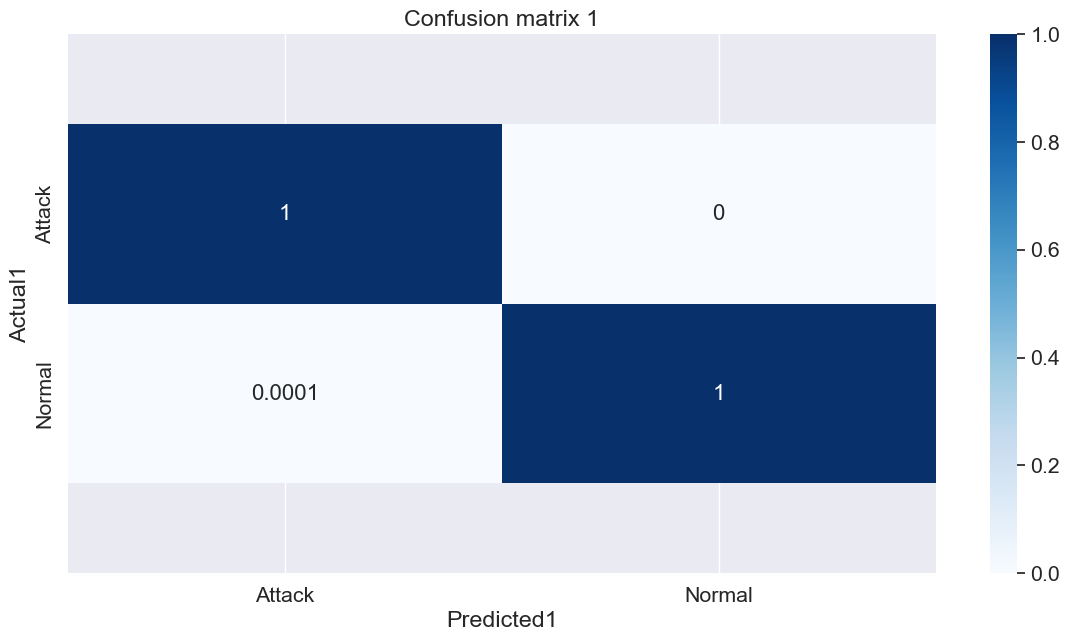

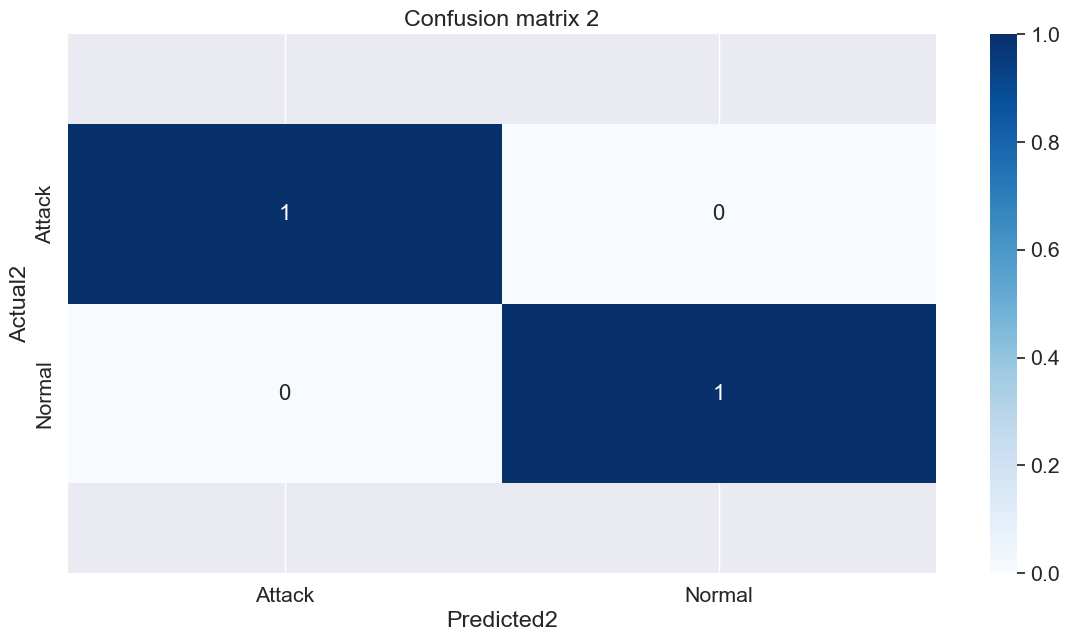

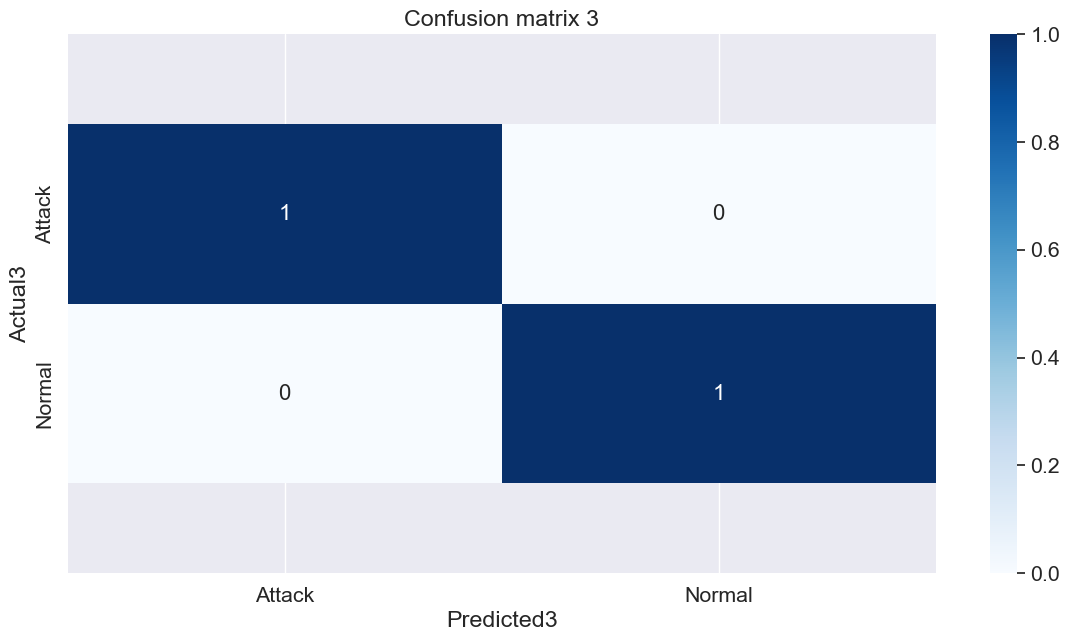

In [16]:


df1_cm =  pd.crosstab(y1_actu, y1_pred, rownames=['Actual1'], colnames=['Predicted1'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df1_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Confusion matrix 1')

df2_cm =  pd.crosstab(y2_actu, y2_pred, rownames=['Actual2'], colnames=['Predicted2'],
                            dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df2_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Confusion matrix 2')

df3_cm =  pd.crosstab(y3_actu, y3_pred, rownames=['Actual3'], colnames=['Predicted3'],
                            dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df3_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Confusion matrix 3')


plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [17]:
print("Calculating feature importance scores for model_1...")
importances = model_1.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df_1.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores_model_1.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores_model_1.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

print("#############################################################################################################")

print("Calculating feature importance scores for model_2...")
importances = model_2.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df_2.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores_model_2.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores_model_2.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

print("#############################################################################################################")

print("Calculating feature importance scores for model_3...")
importances = model_3.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df_3.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores_model_3.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores_model_3.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores for model_1...
Feature importance scores saved: ./results_ekip/rf_feature_importance_scores_model_1.pkl

15 most important features
[[22, 'count', 0.1875189508760641],
 [5, 'dst_bytes', 0.16098673201935015],
 [2, 'service', 0.12029210457570073],
 [11, 'logged_in', 0.08226156367415577],
 [31, 'dst_host_count', 0.06566509839348696],
 [4, 'src_bytes', 0.06035329720618884],
 [23, 'srv_count', 0.053361908536103474],
 [36, 'dst_host_srv_diff_host_rate', 0.04347940302650405],
 [1, 'protocol_type', 0.0352055781589058],
 [28, 'same_srv_rate', 0.0320278569003648],
 [35, 'dst_host_same_src_port_rate', 0.02207454968010055],
 [32, 'dst_host_srv_count', 0.022029127042222877],
 [29, 'diff_srv_rate', 0.020025798837547706],
 [3, 'flag', 0.01970257921209688],
 [30, 'srv_diff_host_rate', 0.013943550110218575]]
Sum 15: 0.9389280982490114

#############################################################################################################
Calculating feature i

### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [18]:
print("Calculating performance metrics for model_1...")
cnf_matrix = confusion_matrix(y1_actual_, y1_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy_1 = accuracy_score(y1_actual_, y1_hat)
precision, recall, f_score, support = prf(y1_actual_, y1_hat, average='weighted')
print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                      .format(accuracy_1, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler_model_1.pkl")

print("#############################################################################################################")

print("Calculating performance metrics for model_2...")
cnf_matrix = confusion_matrix(y2_actual_, y2_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy_2 = accuracy_score(y2_actual_, y2_hat)
precision, recall, f_score, support = prf(y2_actual_, y2_hat, average='weighted')

print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                        .format(accuracy_2, precision,
                                                                recall, f_score, metrics_data["FAR"]))
with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler_model_2.pkl")

print("#############################################################################################################")

print("Calculating performance metrics for model_3...")
cnf_matrix = confusion_matrix(y3_actual_, y3_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy_3 = accuracy_score(y3_actual_, y3_hat)
precision, recall, f_score, support = prf(y3_actual_, y3_hat, average='weighted')

print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                        .format(accuracy_3, precision,
                                                                recall, f_score, metrics_data["FAR"]))
with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler_model_3.pkl")






Calculating performance metrics for model_1...
Accuracy : 0.9999683, Precision : 0.9999683, Recall : 0.9999683, F-score : 0.9999683, FAR: 0.0000317
Performance metrics saved: ./results_ekip/metrics_handler_model_1.pkl
#############################################################################################################
Calculating performance metrics for model_2...
Accuracy : 0.9999663, Precision : 0.9999663, Recall : 0.9999663, F-score : 0.9999663, FAR: 0.0000337
Performance metrics saved: ./results_ekip/metrics_handler_model_2.pkl
#############################################################################################################
Calculating performance metrics for model_3...
Accuracy : 0.9999745, Precision : 0.9999745, Recall : 0.9999745, F-score : 0.9999745, FAR: 0.0000255
Performance metrics saved: ./results_ekip/metrics_handler_model_3.pkl


### GRAPHES



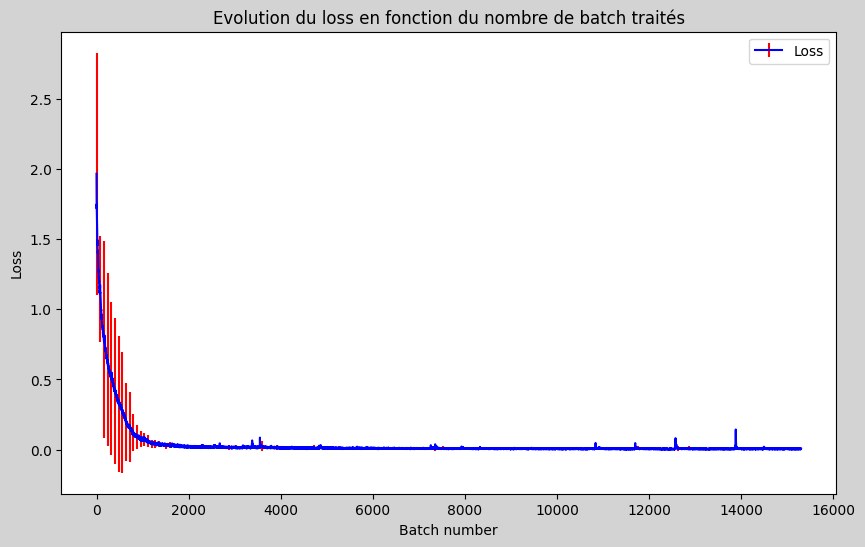

14.453278446197452
Consommation énergétique moyenne du CPU: 14.453278446197452


NameError: name 'accuracy_1' is not defined

In [5]:
couleurs = ['blue','orange','green','red']
"""
with open(results_path+"jeu_de_donnees/" +"dic_loss.pkl", 'rb') as file:
    dic_loss = pkl.load(file)
x = range(len(dic_loss["entrainement_1"]['epoch_0']))

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

#init losses
losses = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}
std_loss = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}
# print(losses)
# print(std_loss)

#Calcul de la somme des losses pour chaque tentative et à chaque epoch
for tentative in dic_loss.keys():
    # print(tentative)
    for epoch in dic_loss[tentative].keys():
        # print(epoch)
        for v_loss in range(len(losses[epoch])):
            # print(f"loss courant: {losses[epoch][v_loss]} / somme: {dic_loss[tentative][epoch][v_loss]}")
            losses[epoch][v_loss] += dic_loss[tentative][epoch][v_loss]

#Mise à jour du dico loss en mode moyenne
losses = {j: [i/len(dic_loss.keys()) for i in losses[j]] for j in dic_loss["entrainement_1"].keys()}
# print("losses:",losses)

#Préparation des barres d'erreurs
# print("std_loss")
for _,dic_epochs in dic_loss.items():
    for e,l in dic_epochs.items():
        # print(f"e = {e}, l = {l}")
        for i in range(len(l)):
            # print(f"l[{i}] = {l[i]}, losses[{e}][{i}] = {losses[e][i]}")
            std_loss[e][i] += (l[i] - losses[e][i])**2
            # print(std_loss[e][i])

for i in std_loss.keys():
    std_loss[i] = [np.sqrt(std_loss[i][j]/len(dic_loss.keys())) if j%50==0 else 0 for j in range(len(std_loss[i]))]

c=0
for i in losses.keys():
    plt.errorbar(x, losses[i], yerr=std_loss[i], label=i, color=couleurs[c])
    c+=1
                 
#Graphe général
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_with_uncertainty.png')  # Sauvegarder la figure

#Graphe précis (à partir de la 2ème epoch)
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
print(std_loss)
c=0
for i in losses.keys():
    if i != "epoch_0":
        plt.plot(x, losses[i], label=i,color=couleurs[c])
    c+=1

plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités (sans la première epoch)')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_epoch2.png')


with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
        pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)


#Partie émissions
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
liste_x = []
liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []

with open("emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=';')
    for ligne in lecteur:
        print(ligne)
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions (Co2 eq in kg)"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy (kWh)"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy (kWh)"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy (kWh)"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed (kWh)"])*1000)
            liste_x.append(ligne['project_name'])



plt.plot(liste_x,liste_emissions_y,label="Emissions de CO2 (kg)",color="blue",marker='+')
plt.xlabel('Modèle')
plt.ylabel('Emission de CO2 (kg)')
plt.title('Emissions de CO2 en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/emission_Co2.png')

#partie consommation
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

plt.plot(liste_x,liste_cpu_energy_y,label="Energie consommée par le CPU (Wh)",color="orange",marker='+')
plt.plot(liste_x,liste_gpu_energy_y,label="Energie consommée par le GPU (Wh)",color="green",marker='+')
plt.plot(liste_x,liste_ram_energy_y,label="Energie consommée par la RAM (Wh)",color="red",marker='+')
plt.plot(liste_x,liste_total_energy_y,label="Energie totale consommée (Wh)",color="purple",marker='+')

plt.xlabel('Modèle')
plt.ylabel('Consommation énergétique (Wh)')
plt.title('Consommation énergétique en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/conso_electrique.png')

plt.show()

#Conservation des données
dico_enviro = {}
dico_enviro["emissions"] = liste_emissions_y
dico_enviro["cpu_energy"] = liste_cpu_energy_y
dico_enviro["gpu_energy"] = liste_gpu_energy_y
dico_enviro["ram_energy"] = liste_ram_energy_y
dico_enviro["total_energy"] = liste_total_energy_y
dico_enviro["liste_x"] = liste_x

with open(results_path+"jeu_de_donnees/"+"dico_enviro.pkl", 'wb') as file:
        pkl.dump(dico_enviro, file)

"""
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import statistics as stat
import math

def confidence_interval(data,confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    se = st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2.,n-1)
    return h


with open(results_path+"jeu_de_donnees/"+"dic_loss_1.pkl", 'rb') as file:
    dic_loss_1 = pkl.load(file)
with open(results_path+"jeu_de_donnees/"+"dic_loss_2.pkl", 'rb') as file:
    dic_loss_2 = pkl.load(file)
with open(results_path+"jeu_de_donnees/"+"dic_loss_3.pkl", 'rb') as file:
    dic_loss_3 = pkl.load(file)

liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []
liste_x = []


with open("emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=',')
    for ligne in lecteur:
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed"])*1000)
            liste_x.append(ligne['project_name'])


#EVOLUTION DU LOSS MOYENNÉ
x = range(min(len(dic_loss_1["entrainement_1"]),len(dic_loss_2["entrainement_2"]),len(dic_loss_3["entrainement_3"])))

losses = [0 for i in range(min(len(dic_loss_1["entrainement_1"]),len(dic_loss_2["entrainement_2"]),len(dic_loss_3["entrainement_3"])))]

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

for i in range((min(len(dic_loss_1["entrainement_1"]),len(dic_loss_2["entrainement_2"]),len(dic_loss_3["entrainement_3"])))):
    
    losses[i] += dic_loss_1["entrainement_1"][i]
    losses[i] += dic_loss_2["entrainement_2"][i]
    losses[i] += dic_loss_3["entrainement_3"][i]

losses = [i/3 for i in losses]
#barres d'erreurs
std_loss = []
transfert = {"entrainement_1":dic_loss_1["entrainement_1"],
             "entrainement_2":dic_loss_2["entrainement_2"],
             "entrainement_3":dic_loss_3["entrainement_3"]}


for i in range(min(len(transfert["entrainement_1"]),len(transfert["entrainement_2"]),len(transfert["entrainement_3"]))):
    data = [transfert[j][i] for j in transfert.keys()]
    std_loss.append(confidence_interval(data))


plt.errorbar(x, losses, yerr=[std_loss[i] if (i%80==0) else 0 for i in range(len(losses))],label="Loss",color=couleurs[0], ecolor='red')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.show()

    

with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
        pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)



#Consommation énergétique moyenne
print(sum(liste_cpu_energy_y)/3)
conso_CPU = np.mean(liste_cpu_energy_y)
print("Consommation énergétique moyenne du CPU:",conso_CPU)
with open(results_path+"jeu_de_donnees/"+"conso_CPU.pkl", 'wb') as file:
        pkl.dump(conso_CPU, file)

#ACCURACY moyenne

accuracy = (accuracy_1 + accuracy_2 + accuracy_3)/3
print("accuracy:",accuracy)
with open(results_path+"jeu_de_donnees/"+"accuracy.pkl","wb") as file:
    pkl.dump(accuracy,file)
